### 媒体与认知 Ch7
RNN：numpy 实现 

In [ ]:
import numpy as np
import copy

np.random.seed(1)

In [ ]:
############################################################
## Part 1: Prapare dataset and the sigmoid function ########
############################################################

# prepare the dataset
# max dim of binary numbers we use (also the sequence length)
max_dim = 8
# store binary numbers in a look-up table X
X = np.unpackbits(np.array([range(2**max_dim)],dtype=np.uint8).T,axis=1)


### 媒体与认知 Ch7
CNN：numpy 实现 mnist 识别

In [1]:
import pickle
import numpy as np 
import matplotlib.pyplot as plt 
import random
from utils import Net, NLLLoss, SGD, get_batch

In [2]:
'''
(1) Load MNIST Dataset
'''
## load dataset
def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist['training_images'], mnist['training_labels'], mnist['test_images'], mnist['test_labels']

X_train, Y_train, X_test, Y_test = load()
print('The shape of training data is ', X_train.shape)
print('The shape of training label is ', Y_train.shape)
print('The shape of testing data is ', X_test.shape)
print('The shape of testing label is ', Y_test.shape)

The shape of training data is  (60000, 784)
The shape of training label is  (60000,)
The shape of testing data is  (10000, 784)
The shape of testing label is  (10000,)


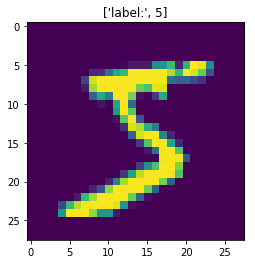

In [3]:
## show the 1st image and label
def show(x,y,K):
    plt.figure("Image")
    plt.imshow(np.reshape(x[K,:],[28,28]))
    plt.title(['label:', y[K]])
    plt.show()

show(X_train,Y_train,0)

In [4]:
## normalize images
def normalize(x):
    print('The range of data is [%d,%d]' % (x.min(), x.max()))
    print('The type of data is %s' % (x.dtype))
    # COMPLETE
    # rearrange x to [-1,1]
    x = (x-x.min()) / x.max()*2 - 1
    print('The range of data is [%f,%f]' % (x.min(), x.max()))
    print('The type of data is %s' % (x.dtype))
    return x

X_train = normalize(X_train)
X_test = normalize(X_test)

The range of data is [0,255]
The type of data is uint8
The range of data is [-1.000000,1.000000]
The type of data is float64
The range of data is [0,255]
The type of data is uint8
The range of data is [-1.000000,1.000000]
The type of data is float64


In [5]:
## convert label to one-hot codes
D_in = X_train.shape[-1] # 784
D_out = 10
def label2OH(y,D_out):
    N = y.shape[0]
    OH = np.zeros((N,D_out))
    OH[np.arange(N), y] = 1
    return OH

def OH2label(OH):
    y = np.argmax(OH, axis=1)
    return y

OH_train = label2OH(Y_train,D_out)
OH_test = label2OH(Y_test,D_out)

## check whether there is sth. wrong with OH
if not OH_train[0,Y_train[0]] or OH2label(OH_train)[0] != Y_train[0]:
    print('Something wrong with OH[0]!')

y = Y_train[1:10]
oh = label2OH(y, 10)
print(y)
print(oh)
y = OH2label(oh)
print(y)

[0 4 1 9 2 1 3 1 4]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[0 4 1 9 2 1 3 1 4]


In [6]:
'''
(2) Construct Model
'''
## ReLU activation layer
class ReLU():
    def __init__(self):
        self.input = None

    def _forward(self, x):
        out = np.maximum(0,x)
        self.input = x
        return out

    def _backward(self, d):
        dX = d*((self.input)>0)

        return dX
    
## check implementation of ReLU by numerial approximation
delta =1e-6
x = np.random.randn(8,10)
e = np.random.randn(8,10)
relu_test = ReLU()
y = relu_test._forward(x)
d = relu_test._backward(e)
d_approx = (relu_test._forward(x+delta*e) - relu_test._forward(x)) / delta
error = np.abs(d - d_approx).mean() / np.abs(d_approx).mean()
print('ReLU error: ', error)

ReLU error:  5.3765621223931464e-11


In [7]:
## Softmax activation layer
class Softmax():
    def __init__(self):
        self.input = None
        self.output = None

    def _forward(self, X):
        Y = np.exp(X - np.tile(X.max(axis=1).reshape([X.shape[0],1]), X.shape[1]))
        Z = Y / np.tile(np.sum(Y, axis=1).reshape([Y.shape[0],1]), Y.shape[1])
        self.input = X
        self.output = Z
        return Z # distribution

    def _backward(self, dout):
        X = self.input
        Z = self.output
        dX = np.zeros(X.shape)
        N = Z.shape[0]
        for n in range(N):
            J = - np.dot(Z[n,:].reshape([Z.shape[1],1]), Z[n,:].reshape([1,Z.shape[1]])) + np.diag(Z[n,:])
            dX[n,:] = np.dot(J,dout[n,:])
        return dX

## check implementation of Softmax by numerial approximation
delta =1e-6
x = np.random.randn(8,10)
e = np.random.randn(8,10)
sm_test = Softmax()
y = sm_test._forward(x)
d = sm_test._backward(e)
d_approx = (sm_test._forward(x+delta*e) - sm_test._forward(x)) / delta
error = np.abs(d - d_approx).mean() / np.abs(d_approx).mean()
print('Softmax error: ', error)

Softmax error:  4.113389936168737e-07


In [8]:
## Fully connected layer
class FC():
    def __init__(self, D_in, D_out):
        self.input = None
        self.W = {'val': np.random.normal(0.0, np.sqrt(2/D_in), (D_in,D_out)), 'grad': 0}
        self.b = {'val': np.random.randn(D_out), 'grad': 0}

    def _forward(self, X):
        out = np.dot(X, self.W['val']) + self.b['val']
        self.input = X
        return out

    def _backward(self, dout):
        X = self.input
        dX = np.dot(dout, self.W['val'].T).reshape(X.shape)
        self.W['grad'] = np.dot(np.sum(X,axis=1).T / X.shape[0], dout)
        self.b['grad'] = dout.mean(axis=0)
        return dX

In [9]:
## Simple 2 layer NN
class SimpleNet(Net):
    def __init__(self, D_in, H, D_out, weights=''):
        self.FC1 = FC(D_in, H)
        self.ReLU1 = ReLU()
        self.FC2 = FC(H, D_out)

        if weights == '':
            pass
        else:
            with open(weights,'rb') as f:
                params = pickle.load(f)
                self.set_params(params)

    def forward(self, X):
        h1 = self.FC1._forward(X)
        a1 = self.ReLU1._forward(h1)
        h2 = self.FC2._forward(a1)
        return h2

    def backward(self, dout):
        dout = self.FC2._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.FC1._backward(dout)

    def get_params(self):
        return [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b]

    def set_params(self, params):
        [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b] = params

In [10]:
## Cross Entropy Loss
class CrossEntropyLoss():
    def __init__(self):
        pass

    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        softmax = Softmax()
        prob = softmax._forward(Y_pred)
        loss = NLLLoss(prob, Y_true)
        Y_serial = np.argmax(Y_true, axis=1)
        dout = prob.copy()
        dout[np.arange(N), Y_serial] -= 1
        return loss, dout

## build simple model
H = 300
model = SimpleNet(D_in, H, D_out)

In [11]:
'''
(3) Training
'''
## Evaluation
def evaluation(model,X,Y):
    pred = model.forward(X)
    result = OH2label(pred) == Y
    result = list(result)
    return result.count(1), X.shape[0]

optim = SGD(model.get_params(), lr=0.0001, reg=0.00003)
criterion = CrossEntropyLoss()

batch_size = 64
EPOCH = 5
BATCH = int(X_train.shape[0] / batch_size)
for e in range(EPOCH):
    ## shuffle data
    index = [i for i in range(X_train.shape[0])]
    random.shuffle(index)
    X_train = X_train[index,:]
    Y_train = Y_train[index]

    for b in range(BATCH):
        ## get batch, covert to one-hot
        X_batch, Y_batch = get_batch(X_train, Y_train, batch_size, b)
        OH_batch = label2OH(Y_batch, D_out)

        ## forward, loss, backward, update weights
        pred = model.forward(X_batch)
        loss, dout = criterion.get(pred, OH_batch)
        model.backward(dout)
        optim.step()

    print("EPOCH %d" % (e))
    # TRAIN SET ACC
    correct_num, total_num = evaluation(model,X_train,Y_train)
    print("TRAIN SET ACC: " + str(correct_num) + " / " + str(total_num) + " = " + str(correct_num/total_num))

    # TEST SET ACC
    correct_num, total_num = evaluation(model,X_test,Y_test)
    print("TEST SET ACC: " + str(correct_num) + " / " + str(total_num) + " = " + str(correct_num/total_num))

## save weights
weights = model.get_params()
with open("weights.pkl","wb") as f:
    pickle.dump(weights, f)

## load weights and test
model = SimpleNet(D_in, H, D_out, "weights.pkl")
print("FINAL TEST")
# TRAIN SET ACC
correct_num, total_num = evaluation(model,X_train,Y_train)
print("TRAIN SET ACC: " + str(correct_num) + " / " + str(total_num) + " = " + str(correct_num/total_num))

# TEST SET ACC
correct_num, total_num = evaluation(model,X_test,Y_test)
print("TEST SET ACC: " + str(correct_num) + " / " + str(total_num) + " = " + str(correct_num/total_num))


EPOCH 0
TRAIN SET ACC: 11920 / 60000 = 0.19866666666666666
TEST SET ACC: 2049 / 10000 = 0.2049
EPOCH 1
TRAIN SET ACC: 16566 / 60000 = 0.2761
TEST SET ACC: 2861 / 10000 = 0.2861
EPOCH 2
TRAIN SET ACC: 23957 / 60000 = 0.3992833333333333
TEST SET ACC: 4043 / 10000 = 0.4043
EPOCH 3
TRAIN SET ACC: 28613 / 60000 = 0.4768833333333333
TEST SET ACC: 4808 / 10000 = 0.4808
EPOCH 4
TRAIN SET ACC: 19391 / 60000 = 0.3231833333333333
TEST SET ACC: 3162 / 10000 = 0.3162
FINAL TEST
TRAIN SET ACC: 19391 / 60000 = 0.3231833333333333
TEST SET ACC: 3162 / 10000 = 0.3162


### 媒体与认知 Ch6
基于SVM的图像分类

In [1]:
from sklearn import svm
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# 装载数据
data = sio.loadmat('homework_ch6/Caltech-256_VGG_10classes.mat')
traindata = data['traindata']
testdata = data['testdata']

# data['traindata'].shape=(1,1)
# data['traindata'][0][0].shape=()
# type(data['traindata'][0][0])=numpy.void
# data['traindata'][0][0][0].shape=(4096,300)
# type(data['traindata'][0][0][0])=numpy.ndarray
x_train = traindata[0][0][0].transpose()  # 转置，shape=(300,4096)
y_train = traindata[0][0][1].ravel()      # 将多维数组转换为一维数组，如果没有必要，不会产生源数据的副本
x_test = testdata[0][0][0].transpose()
y_test = testdata[0][0][1].ravel()

# check if the data have been correctly loaded
# print (x_train.shape)     # (300,4096)
# print (y_train.shape)     # (300,)

# 调用SVM，设置参数，请查看SVC的用法
C = [0.01, 0.1, 0.5, 1.0, 3.0, 10.0]
kernel = ['rbf', 'linear', 'poly', 'sigmoid']
kernel = ['linear']
#C = [0.0, 0.01, 0.1]  # coef0 for sigmoid
for k in kernel:
    print('--------------- kernel: '+ k +' ---------------')
    train_accur = []
    test_accur = []
    for c in C:
        model = svm.SVC(C = c, kernel=k)
        print('C = ', c)
        # 学习模型参数
        model.fit(x_train,y_train)

        # 输出识别准确率
        accur = model.score(x_train,y_train)
        train_accur = train_accur + [accur]
        print ("SVM-training accuracy :", accur)
        y_hat=model.predict(x_train)
        # 计算训练集各类别的识别准确率，请根据准确率定义写出计算公式
        #accur = np.sum(y_hat==y_train) / len(y_hat)
        #print("SVM-training accuracy:", accur)

        accur = model.score(x_test,y_test)
        test_accur = test_accur + [accur]
        print ("SVM-testing accuracy", accur)
        y_hat=model.predict(x_test)
        # 计算测试集各类别的识别准确率，同上
        #accur = np.sum(y_hat==y_test) / len(y_hat)
        #print("SVM-training accuracy:", accur)

        print()

    plt.plot(C,train_accur,label='train_'+k)
    plt.plot(C,test_accur,label='test_'+k)

plt.legend(loc = 0)

--------------- kernel: linear ---------------
C =  0.01
SVM-training accuracy: 1.0
SVM-testing accuracy 0.9151832460732985

C =  0.1
SVM-training accuracy: 1.0
SVM-testing accuracy 0.9151832460732985

C =  0.5
SVM-training accuracy: 1.0
SVM-testing accuracy 0.9151832460732985

C =  1.0
SVM-training accuracy: 1.0
SVM-testing accuracy 0.9151832460732985

C =  3.0
SVM-training accuracy: 1.0
SVM-testing accuracy 0.9151832460732985

C =  10.0
SVM-training accuracy: 1.0
SVM-testing accuracy 0.9151832460732985

